In [82]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point 

from random import *

%qtconsole

In [2]:
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\data\\interim\\'
docs_img_dir = 'C:\\Users\\bryan\\OneDrive\\02 GitHub\\water-pump-tanzania\\docs\\img\\'

## Initial Data Exploration

In [3]:
df_train_val = pd.read_csv(data_raw_dir + 'training_values.csv')
df_test_val = pd.read_csv(data_raw_dir + 'test_values.csv')
print(df_train_val.shape)
print(df_test_val.shape)
print(df_train_val.columns)

df_comp_val = pd.concat([df_train_val,df_test_val]).reset_index(drop=True)

df_comp_val.head(2)

(59400, 40)
(14850, 40)
Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [ ]:
df_train_lab = pd.read_csv(data_raw_dir + 'training_labels.csv')
df_test_lab = pd.read_csv(data_raw_dir + 'test_labels.csv')
print(df_train_lab.shape)
print(df_train_lab.columns)
print(df_train_lab['status_group'].unique())
df_train_lab.head(2)

#### Create Label Definition Dictionary

In [5]:
label_list = ['amount_tsh - Total static head (amount water available to waterpoint)',
'date_recorded - The date the row was entered',
'funder - Who funded the well',
'gps_height - Altitude of the well',
'installer - Organization that installed the well',
'longitude - GPS coordinate',
'latitude - GPS coordinate',
'wpt_name - Name of the waterpoint if there is one',
'num_private - ',
'basin - Geographic water basin',
'subvillage - Geographic location',
'region - Geographic location',
'region_code - Geographic location (coded)',
'district_code - Geographic location (coded)',
'lga - Geographic location',
'ward - Geographic location',
'population - Population around the well',
'public_meeting - True/False',
'recorded_by - Group entering this row of data',
'scheme_management - Who operates the waterpoint',
'scheme_name - Who operates the waterpoint',
'permit - If the waterpoint is permitted',
'construction_year - Year the waterpoint was constructed',
'extraction_type - The kind of extraction the waterpoint uses',
'extraction_type_group - The kind of extraction the waterpoint uses',
'extraction_type_class - The kind of extraction the waterpoint uses',
'management - How the waterpoint is managed',
'management_group - How the waterpoint is managed',
'payment - What the water costs',
'payment_type - What the water costs',
'water_quality - The quality of the water',
'quality_group - The quality of the water',
'quantity - The quantity of water',
'quantity_group - The quantity of water',
'source - The source of the water',
'source_type - The source of the water',
'source_class - The source of the water',
'waterpoint_type - The kind of waterpoint',
'waterpoint_type_group - The kind of waterpoint']

label_list = [x.split(' - ') for x in label_list]
label_desc = [y for (x,y) in label_list]
label_list = [x for (x,y) in label_list]

label_dict = {}
label_dict = dict(zip(label_list,label_desc))

## Column Dtype

In [6]:
df_comp_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69746 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74250 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

In [7]:
var = 'id'
def explore_data(var,slice=-len(df_comp_val[var].unique())):
    print(label_dict[var])
    print(df_comp_val[var].dtype)
    print(df_comp_val[var].unique()[slice:])
    print(str(len(df_comp_val[var].unique())) + ' unique values')
    print(str(df_comp_val[var].isna().sum())+' missing or null values')

## Visual Investigation

In [8]:
tza = gpd.read_file(data_raw_dir+'shapefiles\\gis_osm_places_a_free_1.shp')
tza0 = gpd.read_file(data_raw_dir+'shapefiles\\tza_admbnda_adm0_20181019.shp')
tza1 = gpd.read_file(data_raw_dir+'shapefiles\\tza_admbnda_adm1_20181019.shp') 
tza2 = gpd.read_file(data_raw_dir+'shapefiles\\tza_admbnda_adm2_20181019.shp')
tza3 = gpd.read_file(data_raw_dir+'shapefiles\\tza_admbnda_adm3_20181019.shp')

for idx in tza1[tza1['ADM1_EN'] == 'Dar-es-salaam'].index.tolist():
    tza1.loc[idx,'ADM1_EN'] = 'Dar es Salaam'

for idx in tza2[tza2['ADM1_EN'] == 'Dar-es-salaam'].index.tolist():
    tza2.loc[idx,'ADM1_EN'] = 'Dar es Salaam'
    
for idx in tza3[tza3['ADM1_EN'] == 'Dar-es-salaam'].index.tolist():
    tza3.loc[idx,'ADM1_EN'] = 'Dar es Salaam'

In [9]:
tza0.head(1)

,ADM0_EN,ADM0_SW,ADM0_PCODE,geometry
0,United Republic of Tanzania,Jamhuri ya Muungano wa Tanzania,TZ,"MULTIPOLYGON (((40.37704 -10.28385, 40.37401 -..."


In [10]:
tza1.head(1)

,ADM0_EN,ADM0_SW,ADM0_PCODE,ADM1_EN,ADM1_PCODE,geometry
0,United Republic of Tanzania,Jamhuri ya Muungano wa Tanzania,TZ,Arusha,TZ02,"POLYGON ((35.32059 -1.71952, 35.39328 -1.76093..."


In [11]:
tza2.head(1)

,ADM0_EN,ADM0_SW,ADM0_PCODE,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,geometry
0,United Republic of Tanzania,Jamhuri ya Muungano wa Tanzania,TZ,Arusha,TZ02,Arusha,TZ0206,"MULTIPOLYGON (((36.82231 -3.44251, 36.82211 -3..."


In [12]:
tza3.head(1)

,ET_ID,ADM0_EN,ADM0_SW,ADM0_PCODE,ADM1_EN,ADM1_PCODE,ADM2_EN,ADM2_PCODE,ADM3_EN,ADM3_PCODE,geometry
0,0,United Republic of Tanzania,Jamhuri ya Muungano wa Tanzania,TZ,Dodoma,TZ01,Kondoa,TZ0101,Bumbuta,TZ0101011,"POLYGON ((35.93715 -4.59737, 35.93632 -4.59956..."


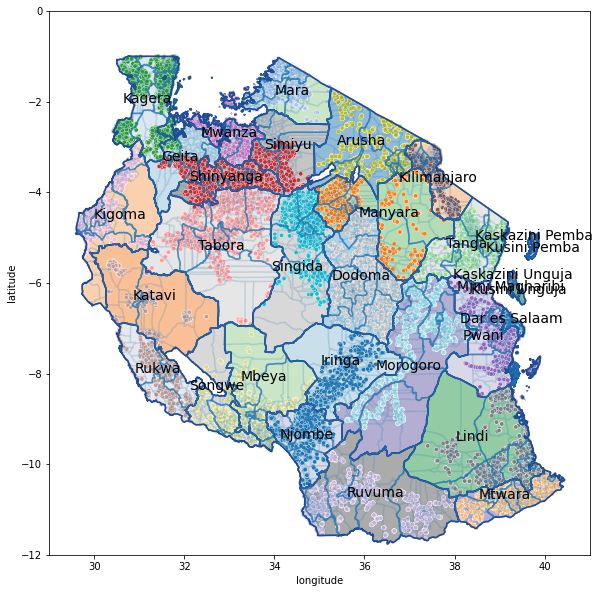

In [13]:
fig = plt.figure(1, figsize=(20,10)) 
ax = fig.add_subplot()

tza0.plot(ax=ax,color='whitesmoke')
tza1.boundary.plot(ax=ax,alpha=1,color='midnightblue')
tza2.boundary.plot(ax=ax,alpha=0.5)
tza3.boundary.plot(ax=ax,alpha=0.1)
tza1.plot(ax=ax,cmap='tab20c',alpha=0.5)
sns.scatterplot(x='longitude',y='latitude',data=df_comp_val,hue='region',
                size=10,palette=sns.color_palette('tab20',21),ax=ax)

tza1.apply(lambda x : ax.annotate(text=x.ADM1_EN,xy=x.geometry.centroid.coords[0],
                                 ha='center',
                                 fontsize=14),axis=1)

ax.set_ylim(-12,0)
ax.set_xlim(29,41)
ax.legend().remove()

Looks like there are some issues in poor labelling between the following regions : 
* Iringa / Njombe
* Mbeya / Songwe
* Rukwa / Katavi
* Kigoma / Tabora
* Shinyanga / Simiyu / Geita
* Kagera / Geita

Let's start with data that is missing location data.

### Data with missing lat / long.

In [14]:
var = 'longitude'
df_comp_val[var].value_counts(sort=True).head(2)

0.000000     2269
35.627125       2
Name: longitude, dtype: int64

In [15]:
missing_loc = df_comp_val[df_comp_val[var]<1].reset_index()

missing_loc['region'].value_counts()

Shinyanga    1259
Mwanza       1010
Name: region, dtype: int64

In [16]:
missing_loc['lga'].value_counts()

Bariadi    1259
Geita       603
Magu        407
Name: lga, dtype: int64

In [17]:
missing_loc['ward'].value_counts()[:10]

Chinamili      135
Bumera         100
Nkololo         94
Kalangalala     86
Somanda         85
Nkoma           78
Sakwe           76
Mkula           74
Nkungulu        72
Sapiwi          57
Name: ward, dtype: int64

Bariadi (Simiyu) / Geita (Geita) are both labels are actually in different regions compared to what the data show (Shinyanga / Mwanza, respectively).

Magu is appropriately located in Mwanza region.

* Does the ward exist in the shapefile? If yes, move missing water pumps to centroid of the ward.

#### Find out which data points are misclassified and create lists to call on

'num_error_none' : the ward and lga are found in the shapefile - region may be incorrect.

In [18]:
num_error_none = []

for num in range(0,len(missing_loc)):

    if tza3[(tza3['ADM3_EN'] == missing_loc['ward'][num]) & (tza3['ADM2_EN'] == missing_loc['lga'][num])].shape[0] == 1 :
        num_error_none.append(num)
        
print(len(num_error_none))

1027


'num_error_all' : the ward and lga are NOT found in the shapefile, accounts for all errors

In [19]:
num_error_all=[]

for num in range(0,len(missing_loc)):

    if tza3[(tza3['ADM3_EN'] == missing_loc['ward'][num]) & (tza3['ADM2_EN'] == missing_loc['lga'][num])].empty:
        num_error_all.append(num)
        
print(len(num_error_all))

1242


'num_error_one' : the ward is in the shapefile and only has one instance, replacement is easy and can be automatic

In [20]:
num_error_one = []

for num in num_error_all:
    if tza3[(tza3['ADM3_EN'] == missing_loc['ward'][num])].shape[0] == 1:
        num_error_one.append(num)

print(len(num_error_one))

790


'num_error_one_plus' : the ward is in the shapefile and has multiple instances, replacement needs some investigation

In [21]:
num_error_one_plus = []

for num in num_error_all:
    if tza3[(tza3['ADM3_EN'] == missing_loc['ward'][num])].shape[0] > 1:
        num_error_one_plus.append(num)

print(len(num_error_one_plus))

316


'num_error_zero' : the ward is NOT in the shapefile, replacement needs some significant investigation for mispellings etc.

In [22]:
num_error_zero = []

for num in num_error_all:
    if tza3[(tza3['ADM3_EN'] == missing_loc['ward'][num])].shape[0] == 0:
        num_error_zero.append(num)

print(len(num_error_zero))

136


#### Start replacement of the region / lga / ward data to make sure can pull coordinates from shapefile

In [23]:
# Replace data for num_error_none

for idx in num_error_none:
    missing_loc.loc[idx,'region'] = tza3[(tza3['ADM3_EN'] == missing_loc.loc[idx,'ward']) & 
                                         (tza3['ADM2_EN'] == missing_loc.loc[idx,'lga'])]['ADM1_EN'].values[0]

In [24]:
# Repeat code for all locations with improper coding with only one instance in the shapefile data, ensure 

for idx in num_error_one:
    missing_loc.loc[idx,'region'] = tza3[tza3['ADM3_EN'] == missing_loc.loc[idx,'ward']]['ADM1_EN'].values[0]
    missing_loc.loc[idx,'lga'] = tza3[tza3['ADM3_EN'] == missing_loc.loc[idx,'ward']]['ADM2_EN'].values[0]


In [25]:
# What about data with multiple instances in shapefile db?
print(str(len(num_error_one_plus))+' of these instances')
unique_one_plus = missing_loc.loc[num_error_one_plus,['region','lga','ward']].drop_duplicates()

print(unique_one_plus)

for idx in unique_one_plus.index.to_list():
    print('')
    print(unique_one_plus[unique_one_plus.index == idx])
    print(tza3[tza3['ADM3_EN'] == missing_loc.loc[idx,'ward']][['ADM1_EN','ADM2_EN','ADM3_EN']])

dict_ward = {}    

# 28 = 3110
dict_ward['Lugulu'] = ['Simiyu','Itilima']

# 40 = 3176
dict_ward['Mkula'] = ['Simiyu','Busega']

# 41 = 3106
dict_ward['Nkoma'] = ['Simiyu','Itilima']

# 48 = 3094
dict_ward['Bumera'] = ['Simiyu','Itilima']

# 165 = 3170
dict_ward['Kiloleli'] = ['Simiyu','Busega']


316 of these instances
        region      lga      ward
28   Shinyanga  Bariadi    Lugulu
40      Mwanza     Magu     Mkula
41   Shinyanga  Bariadi     Nkoma
48   Shinyanga  Bariadi    Bumera
165     Mwanza     Magu  Kiloleli

       region      lga    ward
28  Shinyanga  Bariadi  Lugulu
          ADM1_EN  ADM2_EN ADM3_EN
382   Kilimanjaro     Same  Lugulu
3110       Simiyu  Itilima  Lugulu

    region   lga   ward
40  Mwanza  Magu  Mkula
       ADM1_EN    ADM2_EN ADM3_EN
739   Morogoro  Kilombero   Mkula
3176    Simiyu     Busega   Mkula

       region      lga   ward
41  Shinyanga  Bariadi  Nkoma
     ADM1_EN  ADM2_EN ADM3_EN
3106  Simiyu  Itilima   Nkoma
3117  Simiyu    Meatu   Nkoma

       region      lga    ward
48  Shinyanga  Bariadi  Bumera
     ADM1_EN  ADM2_EN ADM3_EN
2696    Mara   Tarime  Bumera
3094  Simiyu  Itilima  Bumera

     region   lga      ward
165  Mwanza  Magu  Kiloleli
        ADM1_EN  ADM2_EN   ADM3_EN
2257  Shinyanga  Kishapu  Kiloleli
3170     Simiyu   Buseg

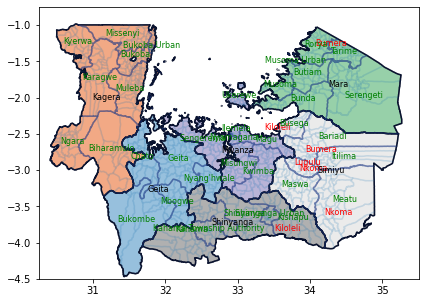

In [26]:
# Visually explore the missing data points to properly label the points

tza_N1 = tza1[(tza1['ADM1_EN'] == 'Simiyu') | (tza1['ADM1_EN'] == 'Mwanza') | (tza1['ADM1_EN'] == 'Mara') | (tza1['ADM1_EN'] == 'Shinyanga') | (tza1['ADM1_EN'] == 'Geita') | (tza1['ADM1_EN'] == 'Kagera')]
tza_N2 = tza2[(tza2['ADM1_EN'] == 'Simiyu') | (tza2['ADM1_EN'] == 'Mwanza') | (tza2['ADM1_EN'] == 'Mara') | (tza2['ADM1_EN'] == 'Shinyanga') | (tza2['ADM1_EN'] == 'Geita') | (tza2['ADM1_EN'] == 'Kagera')]
tza_N3 = tza3[(tza3['ADM1_EN'] == 'Simiyu') | (tza3['ADM1_EN'] == 'Mwanza') | (tza3['ADM1_EN'] == 'Mara') | (tza3['ADM1_EN'] == 'Shinyanga') | (tza3['ADM1_EN'] == 'Geita') | (tza3['ADM1_EN'] == 'Kagera')]

fig = plt.figure(1, figsize=(7,5)) 
ax = fig.add_subplot()

tza_N1.boundary.plot(ax=ax,alpha=1,color='black')
tza_N2.boundary.plot(ax=ax,alpha=0.3,color='midnightblue')
tza_N3.boundary.plot(ax=ax,alpha=0.1)

tza_N1.plot(ax=ax,cmap='tab20c',alpha=0.5)

tza_N_ward = tza_N3[(tza_N3['ADM3_EN'] == 'Kiloleli') | (tza_N3['ADM3_EN'] == 'Lugulu') | (tza_N3['ADM3_EN'] == 'Nkoma') | (tza_N3['ADM3_EN'] == 'Bumera')]

tza_N_ward.apply(lambda x : ax.annotate(text=x.ADM3_EN,xy=x.geometry.centroid.coords[0],
                                 ha='center',color='Red',
                                 fontsize=8),axis=1)

tza_N2.apply(lambda x : ax.annotate(text=x.ADM2_EN,xy=x.geometry.centroid.coords[0],
                                 ha='center',color='Green',
                                 fontsize=8),axis=1)

tza_N1.apply(lambda x : ax.annotate(text=x.ADM1_EN,xy=x.geometry.centroid.coords[0],
                                 ha='center',
                                 fontsize=8),axis=1)


ax.set_ylim(-4.5,-0.75)
ax.set_xlim(30.25,35.5);

In [27]:
# Repeat code for all locations with improper coding with multiple instances in the shapefile data

for idx in num_error_one_plus:
    missing_loc.loc[idx,'region'] = dict_ward[missing_loc.loc[idx,'ward']][0]
    missing_loc.loc[idx,'lga'] = dict_ward[missing_loc.loc[idx,'ward']][1]

In [28]:
# What about data with zero instances in shapefile db?
print(str(len(num_error_zero))+' of these instances')
unique_zero = missing_loc.loc[num_error_zero,['region','lga','ward']].drop_duplicates()

print(unique_zero)

136 of these instances
        region      lga        ward
14   Shinyanga  Bariadi   Mwaubingi
22   Shinyanga  Bariadi    Gamboshi
54   Shinyanga  Bariadi   Mwadobana
70      Mwanza     Magu  Mwananyili
172     Mwanza    Geita      Kakora


In [29]:
dict_ward['Mwaubingi'] = ['Simiyu','Bariadi','Mwaubinge']
dict_ward['Gamboshi'] = ['Simiyu','Bariadi','Gambosi']
dict_ward['Mwadobana'] = ['Simiyu','Bariadi','Madobana']
dict_ward['Kakora'] = ['Geita',"Nyang'hwale",'Kakura']

# Cannot find anything with Mwanayili will drop these rows.
mwanayili_missing = missing_loc[missing_loc.ward == 'Mwananyili'].index.to_list()
missing_loc = missing_loc.drop(mwanayili_missing)

num_error_zero = [i for i in num_error_zero if i not in mwanayili_missing]

for idx in num_error_zero:
    missing_loc.loc[idx,'region'] = dict_ward[missing_loc.loc[idx,'ward']][0]
    missing_loc.loc[idx,'lga'] = dict_ward[missing_loc.loc[idx,'ward']][1]
    missing_loc.loc[idx,'ward'] = dict_ward[missing_loc.loc[idx,'ward']][2]


In [30]:
for idx in missing_loc.index.to_list():
    
    centroid = tza3[(tza3['ADM3_EN'] == missing_loc.loc[idx,'ward']) & (tza3['ADM2_EN'] == missing_loc.loc[idx,'lga'])].geometry.centroid
    
    missing_loc.loc[idx,'longitude'] = centroid.x.values[0]
    missing_loc.loc[idx,'latitude'] = centroid.y.values[0]

<ipython-input-30-a0d771fe506d>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = tza3[(tza3['ADM3_EN'] == missing_loc.loc[idx,'ward']) & (tza3['ADM2_EN'] == missing_loc.loc[idx,'lga'])].geometry.centroid


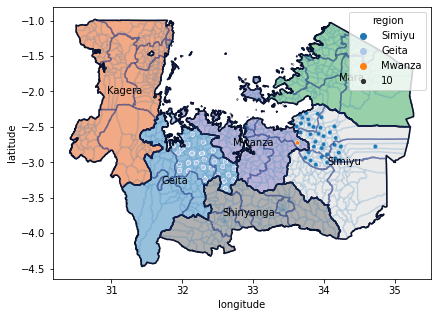

In [31]:
fig = plt.figure(1, figsize=(7,5)) 
ax = fig.add_subplot()

tza_N1.boundary.plot(ax=ax,alpha=1,color='black')

tza_N2.boundary.plot(ax=ax,alpha=0.3,color='midnightblue')
tza_N3.boundary.plot(ax=ax,alpha=0.1)

tza_N1.plot(ax=ax,cmap='tab20c',alpha=0.5)

tza_N_ward = tza_N3[(tza_N3['ADM3_EN'] == 'Kiloleli') | (tza_N3['ADM3_EN'] == 'Lugulu') | (tza_N3['ADM3_EN'] == 'Nkoma') | (tza_N3['ADM3_EN'] == 'Bumera')]

tza_N1.apply(lambda x : ax.annotate(text=x.ADM1_EN,xy=x.geometry.centroid.coords[0],
                                 ha='center',
                                 fontsize=10),axis=1)

sns.scatterplot(x='longitude',y='latitude',data=missing_loc,hue='region',
                size=10,palette=sns.color_palette('tab20',missing_loc.region.nunique()),ax=ax);


In [32]:
missing_loc = missing_loc.set_index('index')

for idx in missing_loc.index.to_list():
    df_comp_val.loc[idx,:] = missing_loc.loc[idx,'id':]
    
# Drop Mwananlili values that were ignored before.
df_comp_val = df_comp_val.drop(df_comp_val[df_comp_val.longitude < 25].index.to_list()).reset_index(drop=True)

## Data with incorrect region



In [33]:
# Make "not_in_shape" (df of indeces and region) and compile list of df_comp_val[region] that are not within shape_region
region_list = df_comp_val['region'].unique().tolist()

not_in_shape = pd.DataFrame(columns=['index','region','longitude','latitude'])

for region in region_list:
    shape_region = tza1[tza1['ADM1_EN']==region].geometry.reset_index() 
    
    region_idx_list = df_comp_val[df_comp_val['region']==region].index.to_list()
    
    for idx in region_idx_list:
        # Create point from lat / long on idx
        point = gpd.GeoDataFrame({'geometry' : [Point(df_comp_val.loc[idx,'longitude'],
                                 df_comp_val.loc[idx,'latitude'])]},crs='EPSG:4326')
        
        if not point.within(shape_region).values[0]:
            not_in_shape = not_in_shape.append(pd.DataFrame({'index':[idx],'region':[region],'longitude':[df_comp_val.loc[idx,'longitude']],'latitude':[df_comp_val.loc[idx,'latitude']]}),ignore_index=True)


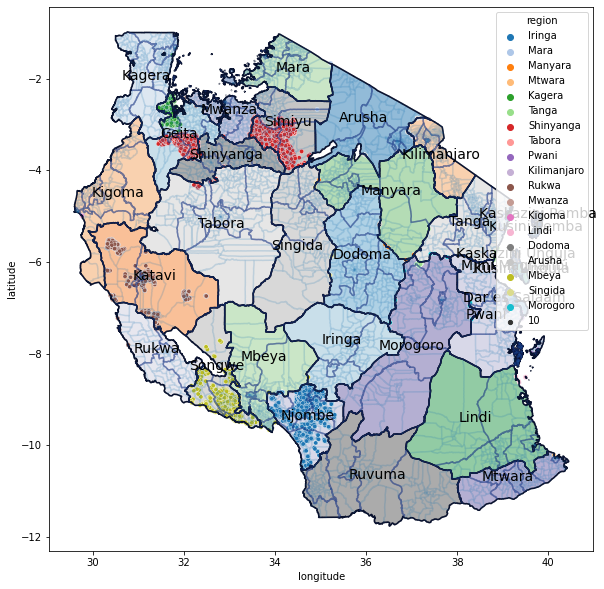

In [34]:
fig = plt.figure(1, figsize=(15,10)) 
ax = fig.add_subplot()

tza1.plot(ax=ax,color='whitesmoke')
tza1.boundary.plot(ax=ax,alpha=1,color='black')
tza2.boundary.plot(ax=ax,alpha=0.3,color='midnightblue')
tza3.boundary.plot(ax=ax,alpha=0.1)
tza1.plot(ax=ax,cmap='tab20c',alpha=0.5)

tza1.apply(lambda x : ax.annotate(text=x.ADM1_EN,xy=x.geometry.centroid.coords[0],
                                 ha='center',
                                 fontsize=14),axis=1)

sns.scatterplot(x='longitude',y='latitude',data=not_in_shape,hue='region',
                palette=sns.color_palette('tab20',not_in_shape.region.nunique()),size=10,ax=ax);


In [35]:
actual_region_list = tza1['ADM1_EN'].to_list()

for idx in not_in_shape.index.tolist() : 
    
    point = gpd.GeoDataFrame({'geometry' : [Point(not_in_shape.loc[idx,'longitude'],
                                                  not_in_shape.loc[idx,'latitude'])]},crs='EPSG:4326')
    
    for region in actual_region_list: 
        
        if not_in_shape.loc[idx,'region'] != region:
            shape_region = tza1[tza1['ADM1_EN']==region].geometry.reset_index() 
    
            if point.within(shape_region).values[0]:
                not_in_shape.loc[idx,'actual_region'] = region


In [36]:
not_in_shape_null = not_in_shape[not_in_shape.actual_region.isnull()]

# A few points are on, outside, or very close to the boundary and need to be manually picked.
for region in not_in_shape_null.region.unique().tolist():
    for idx in not_in_shape_null[not_in_shape_null.region==region].index.to_list():
        not_in_shape.loc[idx,'actual_region'] = region

region_songwe = [8898,8899]

for idx in region_songwe:
    not_in_shape.loc[idx,'actual_region'] = 'Songwe'    
    
for idx in not_in_shape.index.tolist():
    df_comp_val.loc[[not_in_shape.loc[idx,'index']],'region'] = not_in_shape.loc[idx,'actual_region']
    

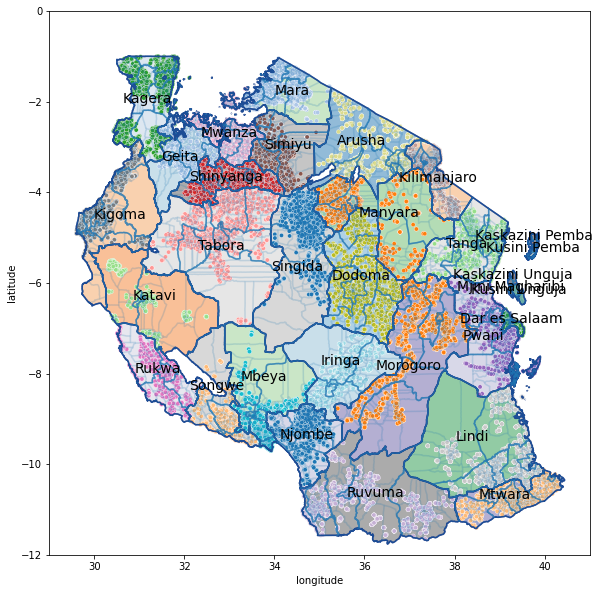

In [37]:
fig = plt.figure(1, figsize=(20,10)) 
ax = fig.add_subplot()

tza0.plot(ax=ax,color='whitesmoke')
tza1.boundary.plot(ax=ax,alpha=1,color='midnightblue')
tza2.boundary.plot(ax=ax,alpha=0.5)
tza3.boundary.plot(ax=ax,alpha=0.1)
tza1.plot(ax=ax,cmap='tab20c',alpha=0.5)
sns.scatterplot(x='longitude',y='latitude',data=df_comp_val,hue='region',
                size=10,palette=sns.color_palette('tab20',df_comp_val.region.nunique()),ax=ax)

tza1.apply(lambda x : ax.annotate(text=x.ADM1_EN,xy=x.geometry.centroid.coords[0],
                                 ha='center',
                                 fontsize=14),axis=1)

ax.set_ylim(-12,0)
ax.set_xlim(29,41)
ax.legend().remove()

In [38]:
df_comp_val_region_fixed = df_comp_val 

## Data with incorrect lga

In [39]:
# Make "not_in_shape" (df of indeces and lga) and compile list of df_comp_val[region] that are not within shape_region
lga_list = df_comp_val['lga'].unique().tolist()

not_in_shape = pd.DataFrame(columns=['index','region','lga','longitude','latitude'])

for lga in lga_list:
    shape_lga = tza2[tza2['ADM2_EN']==lga].geometry.reset_index() 
    
    lga_idx_list = df_comp_val[df_comp_val['lga']==lga].index.to_list()
    
    if shape_lga.empty:
        # print(df_comp_val[df_comp_val.lga == lga].region.unique() +' / '+lga)
        
        for idx in lga_idx_list:
            not_in_shape = not_in_shape.append(pd.DataFrame({'index':[idx],'region':[df_comp_val.loc[idx,'region']],'lga':[lga],'longitude':[df_comp_val.loc[idx,'longitude']],'latitude':[df_comp_val.loc[idx,'latitude']]}),ignore_index=True)
    else:
        for idx in lga_idx_list:
            # Create point from lat / long on idx
            point = gpd.GeoDataFrame({'geometry' : [Point(df_comp_val.loc[idx,'longitude'],
                                     df_comp_val.loc[idx,'latitude'])]},crs='EPSG:4326')
        
            if not point.within(shape_lga).values[0]:
                not_in_shape = not_in_shape.append(pd.DataFrame({'index':[idx],'region':[df_comp_val.loc[idx,'region']],'lga':[lga],'longitude':[df_comp_val.loc[idx,'longitude']],'latitude':[df_comp_val.loc[idx,'latitude']]}),ignore_index=True)
            

In [40]:
region_list = tza1['ADM1_EN'].to_list()
actual_lga_list = tza2['ADM2_EN'].to_list()

for region in actual_region_list: 

    region_lga_list = tza2[tza2['ADM1_EN']==region].ADM2_EN.unique().tolist()
    
    for idx in not_in_shape[not_in_shape['region']==region].index.tolist() : 
    
        point = gpd.GeoDataFrame({'geometry' : [Point(not_in_shape.loc[idx,'longitude'],
                                                      not_in_shape.loc[idx,'latitude'])]},crs='EPSG:4326')      
        
        for lga in region_lga_list:
        
            if not_in_shape.loc[idx,'lga'] != lga:
                shape_region = tza2[tza2['ADM2_EN']==lga].geometry.reset_index() 
    
                if point.within(shape_region).values[0]:
                    not_in_shape.loc[idx,'actual_lga'] = lga

lga_null = not_in_shape[not_in_shape.actual_lga.isnull()]               

In [41]:
lga_kyela = [17874,17881]
lga_misungwi = [15174]
lga_tanga_urban = [17780]
lga_mtwara = [19627,19770]
lga_uvinza = [21332,21337,21396]

lga_geita_chato = [17841,17842,17843,17844]

# A few points are on, outside, or very close to the boundary and need to be manually picked.
for lga in lga_null.lga.unique().tolist():
    for idx in lga_null[lga_null.lga==lga].index.to_list():
        not_in_shape.loc[idx,'actual_lga'] = lga

for idx in lga_kyela:
    not_in_shape.loc[idx,'actual_lga'] = 'Kyela'    

for idx in lga_misungwi:
    not_in_shape.loc[idx,'actual_lga'] = 'Misungwi'   
    
for idx in lga_tanga_urban:
    not_in_shape.loc[idx,'actual_lga'] = 'Tanga Urban'   
    
for idx in lga_mtwara:
    not_in_shape.loc[idx,'actual_lga'] = 'Mtwara'   
    
for idx in lga_uvinza:
    not_in_shape.loc[idx,'actual_lga'] = 'Uvinza'   
    
for idx in lga_geita_chato:
    not_in_shape.loc[idx,'region'] = 'Geita'   
    not_in_shape.loc[idx,'actual_lga'] = 'Uvinza'   
    
for idx in not_in_shape.index.tolist():
    df_comp_val.loc[[not_in_shape.loc[idx,'index']],'region'] = not_in_shape.loc[idx,'region']
    df_comp_val.loc[[not_in_shape.loc[idx,'index']],'lga'] = not_in_shape.loc[idx,'actual_lga']
    

In [42]:
df_comp_val_region_lga_fixed = df_comp_val 

df_comp_val.to_csv(data_interim_dir + 'comp_val_gps_corrected.csv')

### Missing Data

In [43]:
df_comp_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74228 entries, 0 to 74227
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74228 non-null  int64  
 1   amount_tsh             74228 non-null  float64
 2   date_recorded          74228 non-null  object 
 3   funder                 69724 non-null  object 
 4   gps_height             74228 non-null  int64  
 5   installer              69696 non-null  object 
 6   longitude              74228 non-null  float64
 7   latitude               74228 non-null  float64
 8   wpt_name               74228 non-null  object 
 9   num_private            74228 non-null  int64  
 10  basin                  74228 non-null  object 
 11  subvillage             73758 non-null  object 
 12  region                 74228 non-null  object 
 13  region_code            74228 non-null  int64  
 14  district_code          74228 non-null  int64  
 15  lg

The following features do not have full list of observations : 
* 3   funder                 55765 non-null  object 
* 5   installer              55745 non-null  object 
* 11  subvillage             59029 non-null  object 
* 18  public_meeting         56066 non-null  object 
* 20  scheme_management      55523 non-null  object 
* 21  scheme_name            31234 non-null  object 
* 22  permit                 56344 non-null  object 

#### id

In [44]:
var='id'

print(df_comp_val[var].unique())

# type int - index / id value - Good

df_comp_val[var].value_counts(sort=True)[:2]

# no duplicates - no error values

[69572  8776 34310 ... 28749 33492 68707]


0        1
42238    1
Name: id, dtype: int64

#### amount_tsh

In [45]:
var = 'amount_tsh'
explore_data(var,-5)

# type float - some decimal values it looks like - Good

df_comp_val[var].value_counts(sort=True)[:3]

Total static head (amount water available to waterpoint)
float64
[5.90e+01 3.50e+04 3.00e+00 2.55e+03 5.00e-01]
102 unique values
0 missing or null values


0.0         52027
500.0        3874
50.0         3103
1000.0       1858
20.0         1812
            ...  
70000.0         2
53.0            1
250000.0        1
900.0           1
3.0             1
Name: amount_tsh, Length: 84, dtype: int64

In [46]:
# 70% of incomplete data, drop the column.
df_comp_val = df_comp_val.drop(labels=[var],axis=1)

#### date_recorded

In [47]:
var = 'date_recorded'
explore_data(var,-5)

# type object - change to datetime

df_comp_val[var].value_counts(sort=True)[:5]


The date the row was entered
object
['2004-01-12' '2011-09-07' '2004-12-03' '2011-09-22' '2004-01-09']
369 unique values
0 missing or null values


2011-03-17    695
2011-03-15    694
2013-02-03    684
2011-03-16    650
2011-03-14    649
Name: date_recorded, dtype: int64

In [48]:
df_comp_val[var] = pd.to_datetime(df_comp_val[var],format='%Y-%m-%d')

# type datetime - Good

#### funder

In [49]:
var = 'funder'
explore_data(var,-5)

# type string / object - lots of values - Good

print(df_comp_val[var].value_counts(sort=True)[:20])

# 0 values - unknown?

print(str(((df_comp_val[var].value_counts()==1).sum()))+' values have 1 instance')

# lots of potential error in input (romam catholic church vs. Roman Catholic Church, etc.)

Who funded the well
object
['Canaco' 'Banane' 'Nyamigogo' 'Village Fou' 'Velem']
2141 unique values
4504 missing or null values
Government Of Tanzania    11292
Danida                     3907
Hesawa                     2771
Rwssp                      1703
World Bank                 1701
Kkkt                       1623
World Vision               1562
Unicef                     1322
Tasaf                      1136
Dhv                        1065
District Council           1037
Private Individual         1034
Dwsp                       1012
0                           980
Norad                       949
Germany Republi             765
Water                       739
Tcrs                        735
Ministry Of Water           728
Dwe                         605
Name: funder, dtype: int64
1129 values have 1 instance


In [50]:
list_one = df_comp_val[var].value_counts()[df_comp_val[var].value_counts()==1].index.to_list()

for idx in df_comp_val[df_comp_val[var].isin(list_one)].index.to_list():
    df_comp_val.loc[idx,var] = 'other'

for idx in df_comp_val[df_comp_val[var]=='0'].index.to_list():
    df_comp_val.loc[idx,var] = np.nan

#### installer

In [51]:
var = 'installer'
explore_data(var,-5)

# type string / object - lots of values - Good

print(df_comp_val[var].value_counts(sort=True)[:20])

# 0 values - unknown?

print(str(((df_comp_val[var].value_counts()==1).sum()))+' values have 1 instance')

Organization that installed the well
object
['Mombia' 'CANACO' 'Banane' 'MAJIJA CHARLES' 'Central government/TLC']
2410 unique values
4532 missing or null values
DWE                   21739
Government             2275
RWE                    1498
Commu                  1347
DANIDA                 1305
KKKT                   1120
Hesawa                 1070
0                       980
TCRS                    887
CES                     765
Central government      764
DANID                   690
Community               687
HESAWA                  679
District Council        663
World vision            517
TASAF                   504
LGA                     501
WEDECO                  496
District council        490
Name: installer, dtype: int64
1244 values have 1 instance


In [52]:
list_one = df_comp_val[var].value_counts()[df_comp_val[var].value_counts()==1].index.to_list()

for idx in df_comp_val[df_comp_val[var].isin(list_one)].index.to_list():
    df_comp_val.loc[idx,var] = 'other'

for idx in df_comp_val[df_comp_val[var]=='0'].index.to_list():
    df_comp_val.loc[idx,var] = np.nan

print(df_comp_val[df_comp_val['funder'].isnull()].shape[0])
print(df_comp_val[df_comp_val['funder'].isnull() & df_comp_val['installer'].isnull()].shape[0])

# 5419 from both funder and installer, 73 show funder not installer

5484
5419


#### longitude

In [53]:
var = 'longitude'
explore_data(var,-5)

# type float - Good

df_comp_val[var].value_counts(sort=True)

GPS coordinate
float64
[38.85266884 37.45163346 34.7398045  35.43273168 34.76505448]
71937 unique values
0 missing or null values


34.211478    135
34.149346    100
34.167443     94
32.278174     86
33.995811     85
            ... 
37.120792      1
38.801539      1
37.998386      1
39.056631      1
35.164770      1
Name: longitude, Length: 71937, dtype: int64

#### latitude

In [54]:
var = 'latitude'
explore_data(var,-5)

# type float - Good

df_comp_val[var].value_counts(sort=True)

GPS coordinate
float64
[ -6.58284095  -5.35042799  -4.58558667 -10.58415869 -11.22601197]
71936 unique values
0 missing or null values


-2.863661     135
-2.754004     100
-2.656559      94
-2.877503      86
-2.748329      85
             ... 
-3.669355       1
-3.167823       1
-1.844915       1
-3.419036       1
-10.772897      1
Name: latitude, Length: 71936, dtype: int64

#### wpt_name

In [55]:
var = 'wpt_name'
explore_data(var,-5)

# type object - Good

# too many values to be a useful feature

df_comp_val[var].value_counts(sort=True)

Name of the waterpoint if there is one
object
['Mwandami' 'Ikanayugu' 'Kwambwezi' 'Bonde La Mkondoa' 'Kwa Mzee Chagala']
45672 unique values
0 missing or null values


none                4440
Shuleni             2183
Zahanati            1034
Msikitini            646
Kanisani             390
                    ... 
Kwa Amuchi Okaro       1
Kwa Kinyimba           1
Kwa Mzee Bwenge        1
Serengeti A            1
Mafichoni Chini        1
Name: wpt_name, Length: 45672, dtype: int64

#### num_private

In [56]:
var = 'num_private'
explore_data(var,-5)

# type int - very few unique values - not sure what it means so hard to interpret

df_comp_val[var].value_counts(sort=True,normalize=True)[:3]


int64
[  55 1402  669   13  420]
68 unique values
0 missing or null values


0    0.987188
1    0.001266
6    0.001239
Name: num_private, dtype: float64

In [57]:
# 98% of data with value 0
df_comp_val = df_comp_val.drop(labels=[var],axis=1)

#### basin

In [58]:
var = 'basin'
explore_data(var,-5)

df_comp_val[var].value_counts(sort=True,normalize=True)

Geographic water basin
object
['Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']
9 unique values
0 missing or null values


Lake Victoria              0.173102
Pangani                    0.150119
Rufiji                     0.134545
Internal                   0.129897
Lake Tanganyika            0.108477
Wami / Ruvu                0.102077
Lake Nyasa                 0.085305
Ruvuma / Southern Coast    0.075268
Lake Rukwa                 0.041211
Name: basin, dtype: float64

In [59]:
# type object - to category

df_train_val[var] = df_train_val[var].astype('category')

#### subvillage

In [60]:
var = 'subvillage'
explore_data(var,-5)

df_comp_val[var].value_counts(sort=True)

# type object - many unique values - Good

Geographic location
object
['Ilege' 'Mbwenga' 'Kabita' 'Nyamalonda' 'Kosoro']
21414 unique values
470 missing or null values


Shuleni              646
Majengo              631
Madukani             629
Kati                 467
Mtakuja              322
                    ... 
Mgwanga                1
Tambarani              1
Kasingilimi            1
Emaliti                1
Fumagila Magharib      1
Name: subvillage, Length: 21413, dtype: int64

In [61]:
list_one_subvillage = df_comp_val[var].value_counts()[df_comp_val[var].value_counts()==1].index.to_list()

for idx in df_comp_val[df_comp_val[var].isin(list_one_subvillage)].index.to_list():
    df_comp_val.loc[idx,var] = 'other'

#### region

In [62]:
var = 'region'
explore_data(var,-5)

Geographic location
object
['Geita' 'Morogoro' 'Songwe' 'Dar es Salaam' 'Katavi']
26 unique values
0 missing or null values


In [63]:
# type object - few unique values - to categorical, corrected by GPS.

df_train_val[var] = df_train_val[var].astype('category')

#### region_code

In [64]:
var = 'region_code'
explore_data(var,-5)

for rc in df_comp_val['region_code'].unique()[:2]:
    print(df_comp_val[['region','region_code']][df_comp_val.region_code == rc].drop_duplicates())


Geographic location (coded)
int64
[99 24  9  8 40]
27 unique values
0 missing or null values
          region  region_code
0         Njombe           11
38        Iringa           11
4883       Mbeya           11
15904     Simiyu           11
19767  Shinyanga           11
22004   Morogoro           11
       region  region_code
1        Mara           20
71712  Simiyu           20


In [65]:
# values are inconsistent between regions, and region already corrected with GPS coordinates - drop the feature.

df_comp_val = df_comp_val.drop(labels=[var],axis=1)

#### district_code

In [66]:
var = 'district_code'
explore_data(var,-5)

df_comp_val[var].value_counts(sort=True)[:3]

for rc in df_comp_val[var].unique()[:1]:
    print(df_comp_val[['region','lga',var]][df_comp_val[var] == rc].drop_duplicates())


Geographic location (coded)
int64
[30 13  0 80 67]
20 unique values
0 missing or null values
            region             lga  district_code
0           Njombe          Ludewa              5
11          Ruvuma        Namtumbo              5
79           Geita          Mbogwe              5
85          Mwanza       Sengerema              5
89          Dodoma    Dodoma Urban              5
104    Kilimanjaro             Hai              5
119        Manyara          Kiteto              5
142         Tabora         Sikonge              5
213         Songwe           Ileje              5
290       Morogoro         Mvomero              5
320         Mtwara    Mtwara Urban              5
361          Tanga         Kilindi              5
465         Arusha      Ngorongoro              5
515          Tanga         Pangani              5
693          Geita         Bukombe              5
2621      Morogoro        Morogoro              5
3609        Dodoma          Kongwa              5
3788   

In [67]:
# no consistencies between region / lga and district code - remove

df_comp_val = df_comp_val.drop(labels=[var],axis=1)

#### lga

In [68]:
var = 'lga'
explore_data(var,-5)


Geographic location
object
['Masasi  Township Authority' 'Mbeya Urban' 'Tunduma' 'Bukoba Rural'
 'Babati Urban']
159 unique values
0 missing or null values


In [69]:
# type string / object - few unique values - to categorical

df_comp_val.lga = df_comp_val.lga.replace('Bukoba Rural','Bukoba')

df_train_val[var] = df_train_val[var].astype('category')

#### ward

In [70]:
var = 'ward'
explore_data(var,-5)


Geographic location
object
['Sange' "Kang'ata" "Gorong'a" 'Mdabulo' 'Mwalugulu']
2097 unique values
0 missing or null values


In [71]:
# type string / object - unique categorical values - to categorical

df_train_val[var] = df_train_val[var].astype('category')

#### population

In [72]:
var = 'population'
explore_data(var,-5)

print(df_comp_val[var].value_counts().sort_index()[:3])

df_pop_compare = df_comp_val[['population','lga']][df_comp_val['population'] <=1].groupby(by=['lga']).count().merge(right=df_comp_val[['population','lga']].groupby(by=['lga']).count()['population'],on='lga',suffixes=['_invalid','_count_tot'])

Population around the well
int64
[2554 7600 1869 1542 2960]
1128 unique values
0 missing or null values
0    26812
1     8782
2        9
Name: population, dtype: int64


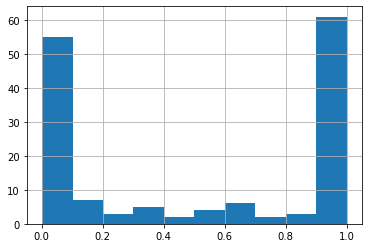

In [73]:
for index in df_pop_compare.index.tolist():
    df_pop_compare.loc[index,'missing_perc'] = df_pop_compare.loc[index,'population_invalid'] / df_pop_compare.loc[index,'population_count_tot']
    
df_pop_compare.missing_perc.hist();

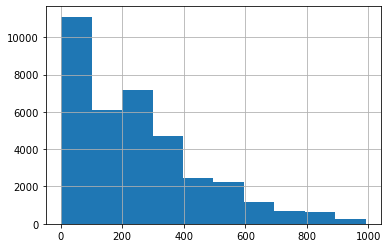

In [74]:
df_comp_val[(df_comp_val.population>1) & (df_comp_val.population < 1000)].population.hist();

# use median for imputing values

In [75]:
region_lga_pop = pd.read_csv(data_interim_dir + 'region_LGA_set.csv',index_col=0)

# For lga where all values missing
for lga in df_pop_compare[df_pop_compare.missing_perc == 1].index.tolist():
    lga_pop_tot = region_lga_pop[region_lga_pop.lga==lga].population.values[0]
    
    lga_pop_mean = np.round(lga_pop_tot / df_pop_compare[df_pop_compare.index == lga].population_invalid.values[0],0)
    
    for idx in df_comp_val[(df_comp_val.lga == lga) & (df_comp_val.population <=1)].index.tolist():
        df_comp_val.loc[idx,'population'] = lga_pop_mean

# For lga where 30% or more values are missing
for lga in df_pop_compare[(df_pop_compare.missing_perc>=0.3) & (df_pop_compare.missing_perc<1)].index.tolist():
    
    lga_pop_tot = region_lga_pop[region_lga_pop.lga==lga].population.values[0]
    lga_pop_act = df_comp_val[df_comp_val.lga==lga].population.sum()
    
    if lga_pop_act > lga_pop_tot:       
        for idx in df_comp_val[(df_comp_val.lga == lga) & (df_comp_val.population <=1)].index.tolist():
            df_comp_val.loc[idx,'population'] = df_comp_val[(df_comp_val.region==df_comp_val[df_comp_val.lga==lga].region.values[0])].population.median()
            
    else:
        for idx in df_comp_val[(df_comp_val.lga == lga) & (df_comp_val.population <=1)].index.tolist():
            df_comp_val.loc[idx,'population'] = np.round((lga_pop_tot - lga_pop_act) / lga_pop_tot / df_pop_compare[df_pop_compare.index == lga].population_invalid.values[0],0)
            
# For lga where 30% or fewer values are missing
for lga in df_pop_compare[(df_pop_compare.missing_perc<0.3)].index.tolist():
    
    lga_pop_tot = region_lga_pop[region_lga_pop.lga==lga].population.values[0]
    lga_pop_act = df_comp_val[df_comp_val.lga==lga].population.sum()
    
    if lga_pop_act > lga_pop_tot:       
        for idx in df_comp_val[(df_comp_val.lga == lga) & (df_comp_val.population <=1)].index.tolist():
            df_comp_val.loc[idx,'population'] = df_comp_val[(df_comp_val.lga==lga)].population.median()
            
    else:
        for idx in df_comp_val[(df_comp_val.lga == lga) & (df_comp_val.population <=1)].index.tolist():
            df_comp_val.loc[idx,'population'] = np.round((lga_pop_tot - lga_pop_act) / lga_pop_tot / df_pop_compare[df_pop_compare.index == lga].population_invalid.values[0],0)    

#### public_meeting

In [76]:
var = 'public_meeting'
explore_data(var,-5)

# type object - to Boolean
# change NaN to False

for idx in df_comp_val[df_comp_val[var].isna()].index.tolist():
    df_comp_val.loc[idx,var] = False

df_comp_val[var] = df_comp_val[var].astype('boolean')

True/False
object
[True nan False]
3 unique values
4155 missing or null values


#### recorded_by

In [77]:
var = 'recorded_by'
explore_data(var,-5)

# one value - can delete this column.

df_comp_val = df_comp_val.drop(labels=[var],axis=1)

Group entering this row of data
object
['GeoData Consultants Ltd']
1 unique values
0 missing or null values


#### scheme_management

In [78]:
var = 'scheme_management'
explore_data(var,-5)

df_comp_val[var].value_counts()

Who operates the waterpoint
object
['Company' 'Parastatal' 'Trust' 'SWC' 'None']
13 unique values
4846 missing or null values


VWC                 45895
WUG                  6496
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
SWC                   123
Trust                  92
None                    1
Name: scheme_management, dtype: int64

In [79]:
df_comp_val[df_comp_val[var].isnull()]['lga'].value_counts()[:5]

Kilombero    766
Kahama       632
Ulanga       505
Kilwa        387
Ukerewe      323
Name: lga, dtype: int64

In [83]:
def create_prob_func_all(df,var):

    prob = df[var].value_counts(normalize=True)

    df_prob = pd.DataFrame(columns=[var,'cum_prob'])

    for idx in range(0,len(prob.index.tolist())):
        df_prob.loc[idx+1,var] = prob.index[idx]
        df_prob.loc[idx+1,'cum_prob'] = prob.iloc[:idx+1].sum()
    
    return df_prob

def create_prob_func_lga(df,var,lga):

    prob = df[df.lga==lga][var].value_counts(normalize=True)

    df_prob = pd.DataFrame(columns=[var,'cum_prob'])

    for idx in range(0,len(prob.index.tolist())):
        df_prob.loc[idx+1,var] = prob.index[idx]
        df_prob.loc[idx+1,'cum_prob'] = prob.iloc[:idx+1].sum()
    
    return df_prob

def create_prob_func_region(df,var,region):

    prob = df[df.region==region][var].value_counts(normalize=True)

    df_prob = pd.DataFrame(columns=[var,'cum_prob'])

    for idx in range(0,len(prob.index.tolist())):
        df_prob.loc[idx+1,var] = prob.index[idx]
        df_prob.loc[idx+1,'cum_prob'] = prob.iloc[:idx+1].sum()
    
    return df_prob

def return_name(df_prob,var):
    return df_prob[df_prob.cum_prob > random()][0:1][var].values[0]

In [84]:
for lga in df_comp_val[df_comp_val[var].isnull()].lga.to_list():
    df_prob = create_prob_func_lga(df_comp_val,var,lga)
    
    for idx in df_comp_val[(df_comp_val[var].isnull()) & (df_comp_val.lga==lga)].index.tolist():
        
        df_comp_val.loc[idx,var] = return_name(df_prob,var)

In [85]:
# type object - few unique values - to category

df_comp_val[var] = df_train_val[var].astype('category')

#### scheme_name

In [86]:
var = 'scheme_name'
explore_data(var,-5)

df_comp_val[var].value_counts()

Who operates the waterpoint
object
['Mradi wa maji wa Buhanda' 'LumeyaKalebezo Nyehunge Water project'
 'Grumeti' 'BL Vetenary' 'MIGA']
2866 unique values
35241 missing or null values


K                             858
None                          794
Borehole                      704
Chalinze wate                 501
M                             490
                             ... 
Uwekule                         1
AIC kahunda                     1
Sawasa water supoly             1
Kwa Mihayo                      1
Ikuna gravity water supply      1
Name: scheme_name, Length: 2865, dtype: int64

In [87]:
# type object - sig num of unique values - LOTS of missing values - drop column

df_comp_val = df_comp_val.drop(labels=[var],axis=1)

#### permit

In [88]:
var = 'permit'
explore_data(var,-5)

df_comp_val[var].value_counts()

If the waterpoint is permitted
object
[False True nan]
3 unique values
3793 missing or null values


True     48584
False    21851
Name: permit, dtype: int64

In [89]:
# type object - to Boolean

for idx in df_comp_val[df_comp_val[var].isna()].index.tolist():
    df_comp_val.loc[idx,var] = False

df_comp_val[var] = df_comp_val[var].astype('boolean')

#### construction_year

Year the waterpoint was constructed
int64
[1969 1981 1964 1966 1965]
55 unique values
0 missing or null values
0       25947
2010     3314
2008     3243
Name: construction_year, dtype: int64


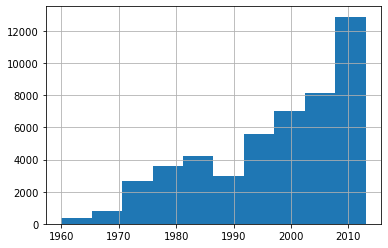

In [90]:
var = 'construction_year'
explore_data(var,-5)

# type int - to datetime

print(df_comp_val[var].value_counts()[:3])

# nearly 1/3 of values are zero (N/A), most likely not a useful column without more data

df_comp_val[df_comp_val[var]!=0].construction_year.hist();

In [91]:
df_cons_compare = df_comp_val[[var,'region']][df_comp_val[var] ==0].groupby(by=['region']).count().merge(right=df_comp_val[[var,'region']].groupby(by=['region']).count()[var],on='region',suffixes=['_invalid','_count_tot'])

for index in df_cons_compare.index.tolist():
    df_cons_compare.loc[index,'missing_perc'] = df_cons_compare.loc[index,'construction_year_invalid'] / df_cons_compare.loc[index,'construction_year_count_tot']

df_cons_compare = df_cons_compare.sort_values(by='missing_perc',ascending=False)

df_cons_compare

,construction_year_invalid,construction_year_count_tot,missing_perc
region,,,
Geita,1548,1548,1.000000
Kagera,3884,3884,1.000000
Tabora,2489,2489,1.000000
Songwe,1718,1718,1.000000
Shinyanga,2525,2525,1.000000
Dodoma,2772,2780,0.997122
Mbeya,4037,4056,0.995316
Simiyu,3187,3405,0.935977
Mwanza,2502,2958,0.845842


In [92]:
# impute construction year for missing_perc year based on overall distribution for regions with high percentage of missing points.
overall_prob_dist = create_prob_func_all(df_comp_val[df_comp_val[var]!=0],var)

for region in df_cons_compare[df_cons_compare.missing_perc>0.8].index.tolist():
    for idx in df_comp_val[(df_comp_val[var]==0) & (df_comp_val.region==region)].index.tolist():
        df_comp_val.loc[idx,var] = return_name(overall_prob_dist,var)

In [93]:
df_cons_compare = df_comp_val[[var,'lga']][df_comp_val[var] ==0].groupby(by=['lga']).count().merge(right=df_comp_val[[var,'lga']].groupby(by=['lga']).count()[var],on='lga',suffixes=['_invalid','_count_tot'])

for index in df_cons_compare.index.tolist():
    df_cons_compare.loc[index,'missing_perc'] = df_cons_compare.loc[index,'construction_year_invalid'] / df_cons_compare.loc[index,'construction_year_count_tot']

df_cons_compare = df_cons_compare.sort_values(by='missing_perc',ascending=False)

df_cons_compare

,construction_year_invalid,construction_year_count_tot,missing_perc
lga,,,
Mafia,170,170,1.000000
Mufindi,440,629,0.699523
Mafinga Township Authority,15,32,0.468750
Mtwara Urban,41,140,0.292857
Nachingwea,108,375,0.288000
...,...,...,...
Ikungi,1,639,0.001565
Babati,1,663,0.001508
Morogoro,1,668,0.001497


In [94]:
# for missing_perc > 40%, use region to impute
for lga in df_cons_compare[df_cons_compare.missing_perc>0.4].index.tolist():
    
    region = df_comp_val[df_comp_val.lga==lga].region.values[0]
    
    region_prob_dist = create_prob_func_region(df_comp_val[df_comp_val[var]!=0],var,region)
    
    for idx in df_comp_val[(df_comp_val[var]==0) & (df_comp_val.region==region)].index.tolist():
        df_comp_val.loc[idx,var] = return_name(region_prob_dist,var)
        
# for missing_perc < 40%, use lga
for lga in df_cons_compare[df_cons_compare.missing_perc<0.4].index.tolist():
    
    lga_prob_dist = create_prob_func_lga(df_comp_val[df_comp_val[var]!=0],var,lga)
    
    for idx in df_comp_val[(df_comp_val[var]==0) & (df_comp_val.lga==lga)].index.tolist():
        df_comp_val.loc[idx,var] = return_name(lga_prob_dist,var)

#### extraction_type

In [95]:
var = 'extraction_type'
explore_data(var)

df_comp_val[var].value_counts()

The kind of extraction the waterpoint uses
object
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']
18 unique values
0 missing or null values


gravity                      33262
nira/tanira                  10197
other                         8097
submersible                   5982
swn 80                        4588
mono                          3621
india mark ii                 3029
afridev                       2207
ksb                           1790
other - rope pump              572
other - swn 81                 284
windmill                       152
india mark iii                 135
cemo                           108
other - play pump              101
walimi                          60
climax                          41
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [96]:
# type object - few unique values - better as categorical

df_comp_val[var] = df_comp_val[var].astype('category')

#### extraction_type_group

In [97]:
var = 'extraction_type_group'
explore_data(var)

df_comp_val[var].value_counts()

The kind of extraction the waterpoint uses
object
['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
13 unique values
0 missing or null values


gravity            33262
nira/tanira        10197
other               8097
submersible         7772
swn 80              4588
mono                3621
india mark ii       3029
afridev             2207
rope pump            572
other handpump       447
wind-powered         152
other motorpump      149
india mark iii       135
Name: extraction_type_group, dtype: int64

In [98]:
# type object - few unique values
# very similar to extraction_type - where are the differences

df_comp_val[var] = df_comp_val[var].astype('category')

#### extraction_type_class

In [99]:
var = 'extraction_type_class'
explore_data(var)

df_comp_val[var].value_counts()

The kind of extraction the waterpoint uses
object
['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']
7 unique values
0 missing or null values


gravity         33262
handpump        20603
other            8097
submersible      7772
motorpump        3770
rope pump         572
wind-powered      152
Name: extraction_type_class, dtype: int64

In [100]:
# type object - to categorical
# similar to other extraction types, less specific
    # why use one over the others?

df_comp_val[var] = df_comp_val[var].astype('category')

#### management

In [101]:
var = 'management'
explore_data(var)

# type string / object - few unique values - to category
    # what is unknown? - few instances
    # water board = water authority?
    # company vs private operator?
    # wug / wua?

df_comp_val[var].value_counts()[:]

How the waterpoint is managed
object
['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
12 unique values
0 missing or null values


vwc                 50602
wug                  8108
water board          3688
wua                  3118
private operator     2504
parastatal           2229
water authority      1123
other                1083
company               859
unknown               683
other - school        126
trust                 105
Name: management, dtype: int64

In [102]:
df_comp_val[var] = df_comp_val[var].astype('category')

#### management_group

In [103]:
var = 'management_group'
explore_data(var)

df_comp_val[var].value_counts()

How the waterpoint is managed
object
['user-group' 'other' 'commercial' 'parastatal' 'unknown']
5 unique values
0 missing or null values


user-group    65516
commercial     4591
parastatal     2229
other          1209
unknown         683
Name: management_group, dtype: int64

In [104]:
# less specific version of management - potential for redundancy

# type string / object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### payment

In [105]:
var = 'payment'
explore_data(var)

df_comp_val[var].value_counts()

What the water costs
object
['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
7 unique values
0 missing or null values


never pay                31696
pay per bucket           11261
pay monthly              10396
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: payment, dtype: int64

In [106]:
# type string / object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### payment_type

In [107]:
var = 'payment_type'
explore_data(var)

df_comp_val[var].value_counts()

What the water costs
object
['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']
7 unique values
0 missing or null values


never pay     31696
per bucket    11261
monthly       10396
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64

In [108]:
# type string / object - to category

# unknown significant, but smaller percentage

df_comp_val[var] = df_comp_val[var].astype('category')

#### water_quality

In [109]:
var = 'water_quality'
explore_data(var)

df_comp_val[var].value_counts()

The quality of the water
object
['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
8 unique values
0 missing or null values


soft                  63484
salty                  6081
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: water_quality, dtype: int64

In [110]:
# unknown small percentage

# type string / object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### quality_group

In [111]:
var = 'quality_group'
explore_data(var)

df_comp_val[var].value_counts()

The quality of the water
object
['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']
6 unique values
0 missing or null values


good        63484
salty        6504
unknown      2345
milky        1005
colored       623
fluoride      267
Name: quality_group, dtype: int64

In [112]:
# unknown small percentage

df_comp_val[var] = df_comp_val[var].astype('category')

#### quantity

In [113]:
var = 'quantity'
explore_data(var)

df_comp_val[var].value_counts()

The quantity of water
object
['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
5 unique values
0 missing or null values


enough          41502
insufficient    18894
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64

In [114]:
# unknown small percentage

df_comp_val[var] = df_comp_val[var].astype('category')

#### quantity_group

In [115]:
var = 'quantity_group'
explore_data(var)

df_comp_val[var].value_counts()

The quantity of water
object
['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
5 unique values
0 missing or null values


enough          41502
insufficient    18894
dry              7782
seasonal         5075
unknown           975
Name: quantity_group, dtype: int64

In [116]:
df_comp_val[df_comp_val['quantity'] != df_comp_val[var]]

,id,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group


In [117]:
# quantity = quantity_group

df_comp_val = df_comp_val.drop(labels=[var],axis=1)

#### source

In [118]:
var = 'source'
explore_data(var)

df_comp_val[var].value_counts()

The source of the water
object
['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']
10 unique values
0 missing or null values


spring                  21216
shallow well            21127
machine dbh             13814
river                   11964
rainwater harvesting     2862
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: source, dtype: int64

In [119]:
# type string / object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### source_type

In [120]:
var = 'source_type'
explore_data(var)

df_comp_val[var].value_counts()

The source of the water
object
['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
7 unique values
0 missing or null values


spring                  21216
shallow well            21127
borehole                14922
river/lake              12914
rainwater harvesting     2862
dam                       840
other                     347
Name: source_type, dtype: int64

In [121]:
# type string / object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### source_class

In [122]:
var = 'source_class'
explore_data(var)

df_comp_val[var].value_counts()

The source of the water
object
['groundwater' 'surface' 'unknown']
3 unique values
0 missing or null values


groundwater    57265
surface        16616
unknown          347
Name: source_class, dtype: int64

In [123]:
# type string / object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### waterpoint_type

In [124]:
var = 'waterpoint_type'
explore_data(var)

df_comp_val[var].value_counts()

The kind of waterpoint
object
['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
7 unique values
0 missing or null values


communal standpipe             35624
hand pump                      21875
other                           8004
communal standpipe multiple     7608
improved spring                  959
cattle trough                    150
dam                                8
Name: waterpoint_type, dtype: int64

In [125]:
# type string / object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

#### waterpoint_type_group

In [126]:
var = 'waterpoint_type_group'
explore_data(var)

df_comp_val[var].value_counts()

The kind of waterpoint
object
['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam']
6 unique values
0 missing or null values


communal standpipe    43232
hand pump             21875
other                  8004
improved spring         959
cattle trough           150
dam                       8
Name: waterpoint_type_group, dtype: int64

In [127]:
# type string / object - to category

df_comp_val[var] = df_comp_val[var].astype('category')

## Review missing data

In [128]:
df_comp_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74228 entries, 0 to 74227
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     74228 non-null  int64         
 1   date_recorded          74228 non-null  datetime64[ns]
 2   funder                 68744 non-null  object        
 3   gps_height             74228 non-null  int64         
 4   installer              68716 non-null  object        
 5   longitude              74228 non-null  float64       
 6   latitude               74228 non-null  float64       
 7   wpt_name               74228 non-null  object        
 8   basin                  74228 non-null  object        
 9   subvillage             73758 non-null  object        
 10  region                 74228 non-null  object        
 11  lga                    74228 non-null  object        
 12  ward                   74228 non-null  object        
 13  p

## Create features

#### year_recorded

In [129]:
var = 'date_recorded'

pd.to_datetime(df_comp_val[var],format='%Y')

0       2011-03-14
1       2013-03-06
2       2013-02-25
3       2013-01-28
4       2011-07-13
           ...    
74223   2011-02-24
74224   2011-03-21
74225   2013-03-04
74226   2013-02-18
74227   2013-02-13
Name: date_recorded, Length: 74228, dtype: datetime64[ns]

#### age_of_pump 

Empty DataFrame
Columns: [id, date_recorded, funder, gps_height, installer, longitude, latitude, wpt_name, basin, subvillage, region, lga, ward, population, public_meeting, scheme_management, permit, construction_year, extraction_type, extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality, quality_group, quantity, source, source_type, source_class, waterpoint_type, waterpoint_type_group]
Index: []

[0 rows x 33 columns]


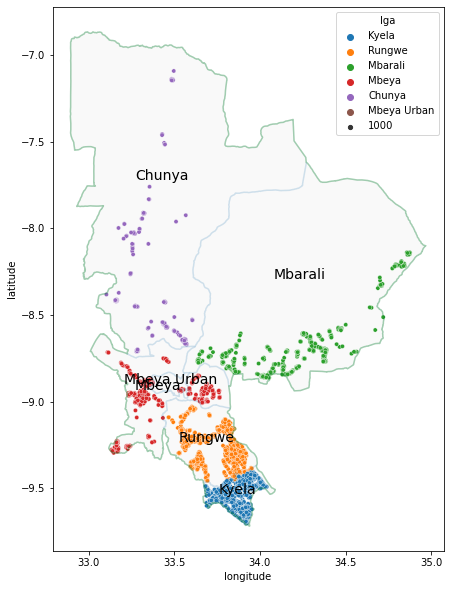

In [130]:
fig = plt.figure(1, figsize=(20,10)) 
ax = fig.add_subplot()

lga_null = not_in_shape[not_in_shape.actual_lga.isnull()]

region_list_null = not_in_shape[not_in_shape.actual_lga.isnull()].region.unique().tolist()
region = 'Mbeya'

tza1[(tza1.ADM1_EN == region)].boundary.plot(ax=ax,alpha=0.3,color='green')
tza2[(tza2.ADM1_EN == region)].boundary.plot(ax=ax,alpha=0.1)

tza1[tza1.ADM1_EN == region].plot(ax=ax,alpha=0.5,color='whitesmoke')
sns.scatterplot(x='longitude',y='latitude',data=df_comp_val[df_comp_val.region==region],hue='lga',
                size=1000,palette=sns.color_palette('tab10',df_comp_val[df_comp_val.region==region].lga.nunique()),ax=ax)

tza2[(tza2.ADM1_EN == region)].apply(lambda x : ax.annotate(text=x.ADM2_EN,xy=x.geometry.centroid.coords[0],
                                 ha='center',
                                 fontsize=14),axis=1)

print(df_comp_val[(df_comp_val.region==region) & (df_comp_val.lga == 'Kisarawe')])

lga_bukoba = [20359, 26544, 64150]
lga_kinondoni = [48594, 25575,43325,62258]

In [131]:
df_comp_val[['region','lga']].drop_duplicates().to_csv(data_raw_dir+'region_LGA_set.csv')